# Applying Principal Component Analysis
Reducing the dimensions to capture variation among candidate "nearest neighbors."

## Setup and specifications

In [75]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

In [3]:
word_list_version = 7

In [4]:
str(word_list_version)

'7'

## Setting up vector database

In [10]:
# Read in vector database as data frame
all_vectors_df = pd.read_csv('wiki-news-300d-1M-subword - no first line - no quote mark.vec', encoding='utf-8', sep=' ', header=None)

In [17]:
all_vectors_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,",",0.0203,-0.0123,-0.0076,0.0187,0.0173,-0.0052,0.0147,0.1364,-0.0435,...,0.0043,0.0269,-0.0427,-0.0267,0.0277,0.0025,0.0063,-0.0154,0.0306,0.0047
1,the,0.0129,0.0026,0.0098,0.0063,0.0102,-0.0002,-0.0056,-0.0829,-0.0420,...,-0.0066,0.0213,0.0053,0.0097,-0.0035,-0.0046,-0.0099,-0.0186,0.0098,0.0019
2,.,0.0049,-0.0030,0.0672,0.0136,-0.0624,0.0077,-0.0257,0.2816,-0.1042,...,-0.0015,0.0286,-0.0633,0.0325,-0.0189,-0.0202,-0.0086,-0.0458,-0.0115,0.0011
3,and,0.0012,-0.0021,-0.0039,0.0048,0.0152,0.0051,0.0023,-0.0461,-0.0189,...,-0.0093,0.0114,0.0190,0.0039,-0.0019,0.0004,0.0060,-0.0001,0.0021,-0.0117
4,of,0.0045,-0.0415,0.0522,0.0169,-0.0966,-0.0374,-0.0040,-0.1236,0.0400,...,-0.0013,0.0072,0.0099,-0.0093,-0.0058,0.0045,-0.0028,-0.0119,-0.0263,0.0068


In [13]:
# Create a dictionary mapping all words in the database to their corresponding row number
# so that the row number can be found immediately given the word
all_vectors_word_index_dict = dict(zip(all_vectors_df[0], range(all_vectors_df.shape[0])))

In [20]:
# Convert the data frame to an array so that each vector can be found immediately
# given the row number
all_vectors_array = np.array(all_vectors_df.drop(0, axis=1))

In [22]:
all_vectors_array.shape

(999993, 300)

## Setting up words on which PCA/KNN model is trained

In [23]:
# Read in list of words
training_word_classifications = pd.read_csv('wordlist_v' + str(word_list_version) + '.csv')
training_word_classifications.head()

,word,vegan,keto,meat
0,avocado,1,1,0
1,bacon,0,1,1
2,baking-powder,1,1,0
3,baking-soda,1,1,0
4,barley,1,0,0


In [24]:
# Isolate the list of words in our training set
training_word_list = list(training_word_classifications["word"])

In [31]:
# Filter to words with corresponding vectors
print("Words sought:", len(training_word_list))
print("Words not found:")
for iword in range(len(training_word_list)):
    if training_word_list[iword] not in all_vectors_word_index_dict:
        print("-", training_word_list[iword])
        training_word_list[iword] = None
training_word_list = [word for word in training_word_list if word is not None]
print("Words found:", len(training_word_list))

Words sought: 77
Words not found:
- baking-soda
- vanilla-extract
Words found: 75


In [33]:
# Create an array of vectors corresponding to the training words.
# Each row corresponds to one word.
# Start by creating the empty matrix:
training_word_vectors = np.zeros((len(training_word_list), all_vectors_array.shape[1]))

In [34]:
# Verify that the matrix is the correct size:
training_word_vectors.shape

(75, 300)

In [44]:
# Populate the matrix with vectors corresponding to the training words
for iword in range(training_word_vectors.shape[0]):
    word_index_in_all_vectors = all_vectors_word_index_dict[training_word_list[iword]]
    training_word_vectors[iword] = all_vectors_array[word_index_in_all_vectors]

## Finding underlying structure, reducing dimensions

In [52]:
# Conduct principal component analysis on selected words
pca = PCA(n_components=5)
fit = pca.fit(training_word_vectors)
training_words_transformed_array = pca.transform(training_word_vectors)
training_words_transformed_df = pd.DataFrame(training_words_transformed_array)
training_words_transformed_df.insert(0, 'word', training_word_list)

In [54]:
training_words_transformed_array.shape

(75, 5)

In [55]:
training_words_transformed_df.head()

,word,0,1,2,3,4
0,avocado,-0.084474,0.036081,0.025121,0.070818,-0.041690
1,bacon,0.079464,0.102724,-0.075510,0.019188,0.001157
2,baking-powder,-0.117417,-0.037822,-0.026220,-0.061549,0.016028
3,barley,-0.046627,-0.047808,-0.024248,0.017874,0.067147
4,basil,-0.149953,0.076276,0.090312,0.027865,-0.026246


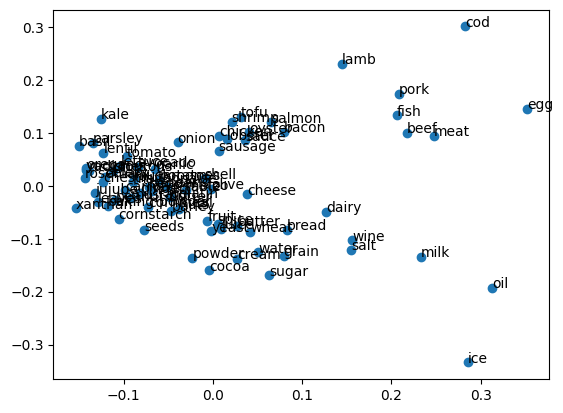

In [67]:
# Hypothesis: Do our two categories of words take up different places in space?
fig, ax = plt.subplots()
ax.scatter(training_words_transformed_array[:,0], training_words_transformed_array[:,1])
for iword in range(training_words_transformed_array.shape[0]):
    plt.text(training_words_transformed_array[iword,0], training_words_transformed_array[iword,1], training_word_list[iword])
plt.show()

## Projecting entire vector database onto principal components

In [68]:
all_vectors_transformed_array = pca.transform(all_vectors_array)

In [69]:
all_vectors_transformed_array.shape

(999993, 5)

## Testing where an arbitrary new word fits in
Next step: give it an arbitrary word, and find that word in the data cloud.

In [72]:
test_word = "omelette"
test_position = all_vectors_transformed_array[all_vectors_word_index_dict["omelette"]]
test_position

array([-0.05439489,  0.09099188, -0.01475223, -0.0792538 , -0.07908093])

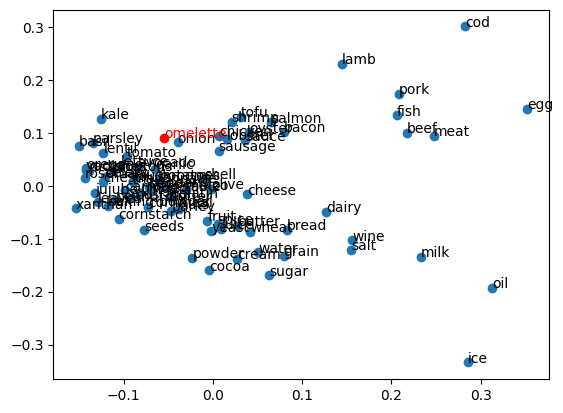

In [73]:
fig, ax = plt.subplots()
ax.scatter(training_words_transformed_array[:,0], training_words_transformed_array[:,1])
ax.scatter(test_position[0], test_position[1], color="red")
for iword in range(training_words_transformed_array.shape[0]):
    plt.text(training_words_transformed_array[iword,0], training_words_transformed_array[iword,1], training_word_list[iword])
plt.text(test_position[0], test_position[1], test_word, color="red")
plt.show()

## Outputting model so we can use it in practice

In [76]:
# To pickle: all_vectors_word_index_dict, all_vectors_transformed_array, training_words_transformed
joblib.dump(all_vectors_word_index_dict, "all_vectors_word_index_dict.pkl")
joblib.dump(all_vectors_transformed_array, "all_vectors_transformed_array.pkl")
joblib.dump(training_words_transformed_df, "training_words_transformed_df.pkl")

['training_words_transformed_df.pkl']